In [37]:
import yaml
import sys
import os
import numpy as np
import torch 
print('START')
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 

exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'
env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

START
Finished loading meshes 0.04314541816711426


In [38]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import copy
import k3d

class Drawer():
    def __init__(self):
        self.im_in_plot = 0
        self.data = []
    def disp_img_1d(self,img,hold=False):
        self.data.append(img)
        
        if not hold:
            fig = plt.figure(figsize=(6*2*len(self.data),7))
            ax = []
            for j,a in enumerate(self.data):
                ax.append( fig.add_subplot(1,len(self.data), j+1)  )
                
                ax[-1].get_xaxis().set_visible(False)
                ax[-1].get_yaxis().set_visible(False)
                pos = ax[-1].imshow( a, cmap='Blues' )
                fig.colorbar(pos, ax=ax[-1])
            plt.show()
            self.data = []
            self.ax = []
            print('SHOW')
            
def plot_two_pcd_line(x, y, point_size=0.005, c1='g', c2='r'):
    if c1 == 'b':
        k = 245
    elif c1 == 'g':
        k = 25811000
    elif c1 == 'r':
        k = 11801000
    elif c1 == 'black':
        k = 2580
    else:
        k = 2580

    if c2 == 'b':
        k2 = 245
    elif c2 == 'g':
        k2 = 25811000
    elif c2 == 'r':
        k2 = 11801000
    elif c2 == 'black':
        k2 = 2580
    else:
        k2 = 2580

    col1 = np.ones(x.shape[0]) * k
    col2 = np.ones(y.shape[0]) * k2
    plot = k3d.plot(name='points')
    plt_points = k3d.points(x, col1.astype(np.uint32), point_size=point_size)
    plot += plt_points
    plt_points = k3d.points(y, col2.astype(np.uint32), point_size=point_size)
    plot += plt_points
    for i in range(min(100,x.shape[0]) ):
        plot += k3d.line([x[i],y[i]],shader='mesh', width=0.0005, color=0xff0000)
    
    plt_points.shader = '3d'
    plot.display()
    
draw = Drawer()

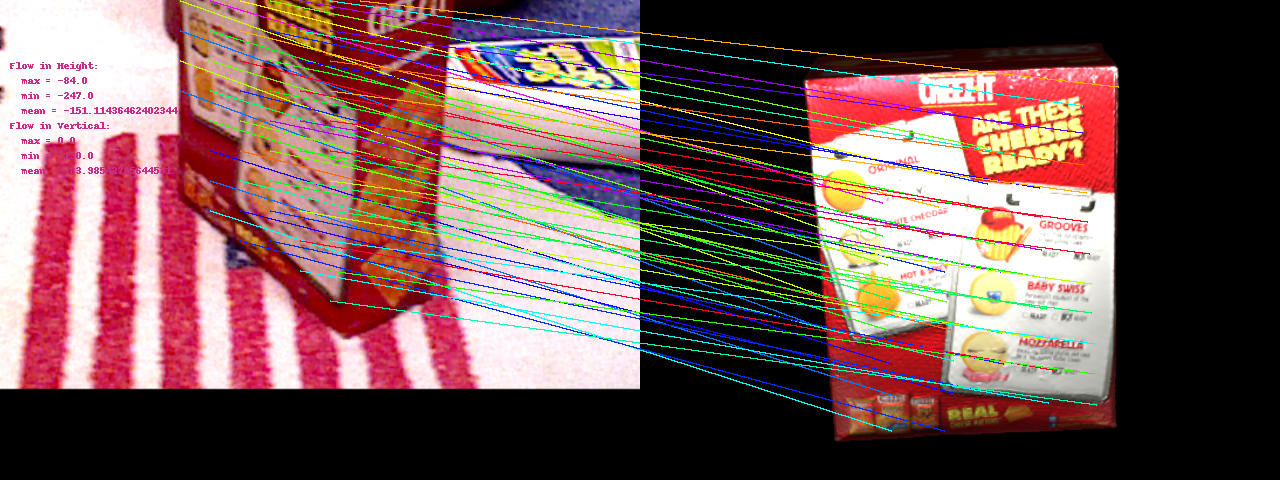

0.7851648330688477


(tensor([237.,  19.], dtype=torch.float64),
 tensor([537., 419.], dtype=torch.float64),
 tensor([40., 36.]),
 tensor([451., 583.]))

In [59]:
import time
st = time.time()
for j in range(0,1):
    i = np.random.randint(0,10000)
    batch = dataset_train[i][0] #bann 10450
    points, choose, img, target, model_points, idx = batch[0:6]
    depth_img, label_img, img_orig, cam = batch[6:10]
    gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

    real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
    pred_rot_wxyz, pred_trans, pred_points, h_render,h_real, render_img_original = batch[18:24]
    u_map, v_map, flow_mask, bb = batch[24:]
    real_tl, real_br, ren_tl, ren_br = bb
    from visu import Visualizer
    visualizer = Visualizer('/home/jonfrey/Debug')
    visualizer.plot_corrospondence('tag', 2, u_map, v_map, flow_mask, real_img, render_img, store=False, jupyter=True, coloful = True)

#     draw = Drawer()
#     draw.disp_img_1d( u_map, True)
#     draw.disp_img_1d( v_map, True)
#     draw.disp_img_1d( flow_mask )
#     # draw.disp_img_1d( gt_label_cropped )

# #     c1[ int(b_real.tl[0]):int(b_real.br[0]), int(b_real.tl[1]):int(b_real.tl[1]+5) ] = 100000
# #     c1[ int(b_real.tl[0]):int(b_real.br[0]), int(b_real.br[1]):int(b_real.br[1]+5) ] = 100000
#     img_orig [ int(b_real.tl[0]):int(b_real.br[0]), int(b_real.tl[1]):int(b_real.tl[1]+5),:] = torch.tensor( [0,255,0] )
#     img_orig [ int(b_real.tl[0]):int(b_real.br[0]), int(b_real.br[1]):int(b_real.br[1]+5),:] = torch.tensor( [0,255,0] )
#     print(b_ren.br, b_ren.tl)
    
#     render_img_original [ int(b_ren.tl[0]):int(b_ren.br[0]), int(b_ren.tl[1]):int(b_ren.tl[1]+5),:] = torch.tensor( [0,255,0] )
#     render_img_original [ int(b_ren.tl[0]):int(b_ren.br[0]), int(b_ren.br[1]):int(b_ren.br[1]+5),:] = torch.tensor( [0,255,0] )

#     display( Image.fromarray(np.uint8(img_orig.numpy())) )
#     display( Image.fromarray(np.uint8(render_img_original.numpy())) )
print(time.time()-st)
bb



In [60]:
from deep_im import flow_to_trafo
import rotations

K_ren = torch.from_numpy( dataset_train._backend.get_camera('data_syn/000001', K=True) )
K_real =  torch.from_numpy(dataset_train._backend.get_camera('data_syn/000001', K=True) )

# print(pred_rot_wxyz[None,:], type(pred_rot_wxyz))
# h_real is nothing else then the gt estimate. Instead use 
o = quat_to_rot(pred_rot_wxyz[None,:], conv='wxyz')
h_real_est = torch.eye(4)
h_real_est[:3,:3] = o
h_real_est[:3,3] = torch.tensor( pred_trans )

# print(h_real_est- h_real)
    
    
P_real, P_ren, P_real_trafo, T_res = flow_to_trafo(
                            real_br, real_tl,ren_br, ren_tl, 
                            flow_mask, 
                            u_map, v_map, 
                            K_real, K_ren, 
                            real_d[0], render_d[0], 
                            h_real_est, h_render)
# print(gt_trans)
# print(pred_trans)

print(f"Do they match {(T_res)[:3,3]} {torch.tensor( gt_trans )- pred_trans} ???")

#print(( h_real_est @ torch.inverse(T_res) ) [:3,3])
#print(( torch.inverse(T_res) @ h_real_est ) [:3,3])
#print(( h_real_est @ T_res ) [:3,3])
#print(( T_res @ h_real_est ) [:3,3])
#print(( h_real) [:3,3])

#print(T_res)


print(f"GT Cam to Obj Center: \n{h_real}")
#print( h_real_est @ T_res )
#h_real_est_new = torch.eye(4)
#h_real_est_new[:3,:3] = h_real_est[:3,:3] @ T_res[:3,:3].T
#h_real_est_new[:3,3] = h_real_est[:3,3] + T_res[:3,3]             

# print(f"Obj Center Estimate to Render: \n{T_res}")
#print(h_real_est_new)
#h_real_est_new[:3,:3] = h_real_est[:3,:3].T @ T_res[:3,:3]
#print(h_real_est_new)

#h_real_est_new[:3,:3] = T_res[:3,:3] @ h_real_est[:3,:3]

th =  T_res @ h_real_est
th[:3,3] = h_real_est[:3,3] + T_res[:3,3]  
print(f"Theorie: \n{th}")

#print(h_real_est_new)
#h_real_est_new[:3,:3] = T_res[:3,:3].T @ h_real_est[:3,:3]
#print(h_real_est_new)

sam = max(1,int(P_real.shape[0]/100))
plot_two_pcd_line(P_real.numpy()[::sam,:], P_ren.numpy()[::sam,:])
plot_two_pcd_line(P_real_trafo.numpy()[::sam,:], P_ren.numpy()[::sam,:])


mp = torch.ones( (model_points.shape[0],4))
mp[:,:3] = model_points

mp1 = (copy.deepcopy(mp) @ th.T )[:,:3]
mp2 = (copy.deepcopy(mp) @ h_real.T )[:,:3]
print(mp1)
sam = max(1,int(mp1.shape[0]/100))
plot_two_pcd_line(mp1.numpy()[::sam,:], mp2.numpy()[::sam,:])


#mp = torch.ones( (model_points.shape[0],4))
#mp[:,:3] = model_points

#mp1 = (copy.deepcopy(mp) @ th.T )[:,:3]
#mp2 = (copy.deepcopy(mp) @ h_real.T )[:,:3]
#print(mp1)
#sam = max(1,int(mp1.shape[0]/100))
#plot_two_pcd_line(mp1.numpy()[::sam,:], mp2.numpy()[::sam,:])


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Do they match tensor([ 0.0027, -0.1150, -0.1005]) tensor([ 2.3748e-06, -9.9985e-02, -9.9996e-02], dtype=torch.float64) ???
GT Cam to Obj Center: 
tensor([[ 0.7629, -0.6430,  0.0675, -0.0857],
        [-0.2589, -0.3994, -0.8794,  0.0337],
        [ 0.5925,  0.6534, -0.4712,  0.9045],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
Theorie: 
tensor([[ 0.7435, -0.6522,  0.1479, -0.0830],
        [-0.1317, -0.3596, -0.9238,  0.0187],
        [ 0.6556,  0.6673, -0.3533,  0.9039],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


Output()

Output()

tensor([[-0.1045, -0.0697,  0.9505],
        [-0.0798,  0.0637,  0.9605],
        [-0.1030, -0.0878,  0.9407],
        ...,
        [-0.0844, -0.0030,  0.9426],
        [-0.1338, -0.0557,  0.8940],
        [-0.1272,  0.0772,  1.0076]])


Output()

In [5]:
sol = gt_trans - pred_trans.numpy()
sol

T_res
torch.inverse(T_res)

tensor([[ 0.9419, -0.0330, -0.3343, -0.0359],
        [ 0.0154,  0.9984, -0.0550,  0.0979],
        [ 0.3356,  0.0466,  0.9409,  0.0952],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [6]:
ten = torch.rand((480,640))
mh = 480
mw = 640

h = torch.arange(1,50,1).type(torch.long)
w = torch.arange(51,100,1).type(torch.long)

index = h*mw + w

out_ten = ten.flatten()
print(out_ten.shape)

print("Out", out_ten[index][:3]) 


for i in range(h.shape[0]):
    print( ten[h[i],w[i]])
    if i > 3:
        break
    
#ind = torch.cat([ind1[:,None],ind2[:,None]],dim=1)
#print(ind)

#ten[ind]
#torch.index_select(ten, (0,1) ,ind)
# , real_tl,ren_br, ren_tl, 
#                             flow_mask, 
#                             u_map, v_map, 
#                             K_real, K_ren, 
#                             real_d[0], render_d[

torch.Size([307200])
Out tensor([0.4134, 0.9593, 0.9826])
tensor(0.4134)
tensor(0.9593)
tensor(0.9826)
tensor(0.9139)
tensor(0.1961)


In [7]:

# Visualize the vectors in the "Current Object Center Frame" for rendered and real 
from visu import plot_pcd
from visu import plot_two_pcd
import k3d
from visu import plot_two_pcd
import copy
    
K_ren = dataset_train._backend.get_camera('data_syn/000001', K=True)
K_real = dataset_train._backend.get_camera('data_syn/000001', K=True)

print(real_d.shape)

P_real, P_ren, P_real_trafo, T_res = calculate_relative_pose(real_br, 
                            real_tl, 
                            ren_br, 
                            ren_tl, 
                            flow_mask, 
                            u_map, 
                            v_map, 
                            K_real, 
                            K_ren, 
                            real_d[0], 
                            render_d[0], 
                            h_real, 
                            h_render)
    
plot_two_pcd_line(P_real[::500,:], P_ren[::500,:])
plot_two_pcd_line(P_real_trafo[::500,:], P_ren[::500,:])



torch.Size([1, 480, 640])


NameError: name 'calculate_relative_pose' is not defined

In [ ]:
# # render_img
# # 
# a = render_d[0].numpy()
# m = np.max( a )

# b = (a/  m) * 255 
# #  print(b[None,:,:].repeat(3,0).shape)
# # c = b[None,:,:].repeat(3,0)
# img = Image.fromarray( b )
# display(img.convert("L") )
# draw.disp_img_1d(render_d[0].numpy())
# draw.disp_img_1d(real_d[0].numpy())
# visualizer.plot_corrospondence('tag', 2, u_map, v_map, flow_mask, real_img, render_img, store=False, jupyter=True, coloful = True)

grid_h, grid_w = np.mgrid[0 :480:1 , 0:640:1]


ren_pixels_c = np.stack( [grid_w[flow_mask] - v_map[flow_mask].numpy(), 
                        grid_h[flow_mask] - u_map[flow_mask].numpy()], axis=1 )
img1 = copy.deepcopy( render_d[0].numpy() )
draw.disp_img_1d(img1, True)
ind = np.zeros( (480,640) )
for i in range(ren_pixels_c.shape[0]):
    ind[ int(  ren_pixels_c[i,1] ) , int( ren_pixels_c[i,0]) ] = 1
ind2 = ind == 1
img2 = copy.deepcopy( img1 )
img2[ ind2 ] = 10000
draw.disp_img_1d(img2)



ren_pixels_c = np.stack( [grid_w[flow_mask], 
                        grid_h[flow_mask]], axis=1 )
img1 = copy.deepcopy( real_d[0].numpy() )
draw.disp_img_1d(img1, True)
ind = np.zeros( (480,640) )
for i in range(ren_pixels_c.shape[0]):
    ind[ int(  ren_pixels_c[i,1] ) , int( ren_pixels_c[i,0]) ] = 1
ind2 = ind == 1
img2 = copy.deepcopy( img1 )
img2[ ind2 ] = 40000
draw.disp_img_1d(img2)

In [ ]:
from visu import plot_two_pcd
def filter_pcd( pcd, tol = 0.5):
    """
    input:
        pcd : Nx3 np.float32
    returns:
        mask : NX3 np.bool 
    """
    m = np.mean(pcd, axis = 0)
    comp = m[None,:].repeat(pcd.shape[0],0) + tol
    mean_free = pcd-m[None,:].repeat(comp.shape[0],0)
    mask = np.linalg.norm( mean_free,  axis= 1) > tol
    # print( f'Invalid Points outside of tol {tol}, {np.sum( mask, axis=0)}')
    
    return mask[:,None].repeat(3,1) == False


m_real = filter_pcd( P_real_in_center[::100,:] )
m_ren = filter_pcd( P_ren_in_center[::100,:] )
m_tot = m_real * m_ren
# use the mask calculated for both



# P_real_in = P_real_in_center[::100,:][m_tot[:,0]]
# P_ren_in = P_ren_in_center[::100,:][m_tot[:,0]]

plot_two_pcd(P_real_in, P_ren_in)


In [ ]:

        
print( torch.from_numpy(P_real_in)[None].shape)
print( torch.from_numpy(P_ren_in).shape)
T = solve_transform( torch.from_numpy(P_real_in)[None] , torch.from_numpy(P_ren_in) ) 
print('R.shape', T)
# print('Inital Trans', pred_trans)
# print('Gt', h_real)

# T @ keypoints == gt_keypoints.
    
print('Delta:',  h_real[:3,3]- pred_trans.numpy())
from visu import plot_two_pcd
import copy

P_h = np.ones( (P_ren_in.shape[0],4 ) )
P_h[:,:3] = P_ren_in

P_hr = np.ones( (P_real_in.shape[0],4 ) )
P_hr[:,:3] = P_real_in

P_real_trafo = (np.linalg.inv( T[0].numpy() ) @ copy.deepcopy(P_hr).T).T
print(P_real_trafo)
P_real_trafo = P_real_trafo[:,:3]
plot_two_pcd_line(P_real_in, P_ren_in)
plot_two_pcd_line(P_real_trafo, P_ren_in)

# plot_two_pcd(P_real_trafo , P_ren_in)
# plot_two_pcd(P_real_in, P_ren_in)

# # plot_two_pcd(P_real_in_center[::100,:], P_ren_trafo[:,:3])
# # plot_two_pcd(P_real_trafo[:,:3], P_ren_in_center[::100,:])
# # plot_two_pcd(, point_size=0.005, c='r')
# # Rrel=RjR−1i and Trel=−RrelTi+Tj.

# h_rel = np.eye(4)
# h_rel[:3,:3] = h_real[:3,:3] @ h_render[:3,:3].T
# h_rel[:3, 3] = h_real[:3,3]- pred_trans.numpy()

# print(h_rel)

# P_h = np.ones( (P_ren_in.shape[0],4 ) )
# P_h[:,:3] = P_ren_in
# P_ren_gt = copy.deepcopy(P_h) @ h_rel


# # Intermediate Goal get this relative position voteing working: Step1
# # Get From Flow the Full Pose Estimate of the Obejct
# # Throw the ADD-S at it !


In [ ]:
import matplotlib.pyplot as plt
cmap = plt.cm.get_cmap('gist_rainbow', 20)
cmaplist = [cmap(i) for i in range(cmap.N)]
import random
print(random.choice(cmaplist)[:3])